In [6]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
from libpysal.graph import read_parquet, Graph
from core.generate_context import spatially_weighted_partial_lag

In [7]:
tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
lag_dir = '/data/uscuni-ulce/processed_data/lag/'
regions_datadir = "/data/uscuni-ulce/"

### Calculate lagged tessellation cell data

In [9]:
spatial_lag = 3
kernel='gaussian'
lag_type = '_'

In [10]:
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

In [12]:
def process_region_lag(region_id):
    print('processing' , region_id)
    X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')
    graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}.parquet")
    tessellation = gpd.read_parquet(
            tessellations_dir + f"tessellation_{region_id}.parquet"
    )
    centroids = shapely.get_coordinates(tessellation.representative_point())
    
    # # label building input data, could work with empty tess as well
    building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
    labels = building_graph.component_labels
    
    lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10, bandwidth=-1)
    lag = lag[[c for c in lag.columns if lag_type in c]]
    lag.to_parquet(f'{lag_dir}{region_id}_{kernel}_lag_{spatial_lag}.parquet')

In [14]:
# %%time
# from joblib import Parallel, delayed
# n_jobs = -1
# new = Parallel(n_jobs=n_jobs)(
#     delayed(process_region_lag)(region_id) for region_id, _ in region_hulls.iterrows()
# )

processing 4


### aggregate lagged tesselation data to morphotopes

In [10]:
spatial_lag = 3
kernel='gaussian'
lag_type = '_'
lag_dir = '/data/uscuni-ulce/processed_data/lag/'
model_params = '_100_0_None_None_False'

def read_lag_data(region_id):
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]
    lag_data = pd.read_parquet(f'{lag_dir}{region_id}_{kernel}_lag_{spatial_lag}.parquet')
    lag_data = lag_data.loc[morphotopes.index]
    data = lag_data.groupby(morphotopes.morphotope_label).agg('median')
    data.index = str(region_id) + '_' + data.index
    return data

In [11]:
### read all morphotopes
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

In [15]:
%%time
for region_id, _ in region_hulls.iterrows():
    print('processing', region_id)
    data = read_lag_data(region_id)
    data.to_parquet(f'/data/uscuni-ulce/processed_data/morphotope_lagged_data/{region_id}_{kernel}_{spatial_lag}.pq')

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765
processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970
processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214
processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662
processing 5671
processing 5766
processi

In [ ]:
### much slower for some reason

# %%time

# from joblib import Parallel, delayed
# n_jobs = -1

# region_hulls = gpd.read_parquet(
#         regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
# )

# for region_id, _ in region_hulls.iterrows():
#     data = Parallel(n_jobs=n_jobs)(
#     delayed(read_lag_data)(region_id) for region_id, _ in region_hulls.iterrows()
# )

In [13]:
%%time
df = pd.concat(data)

CPU times: user 99.5 ms, sys: 77.3 ms, total: 177 ms
Wall time: 176 ms


In [15]:
df.shape


(1046897, 144)

In [16]:
df.to_parquet('../data/morh_lag.pq')

### Try clusters

In [15]:
region_id = 69333


model_params = '_100_0_None_None_False'

In [16]:
morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

In [135]:
clustering_data = clustering_data[clustering_data.index >= 0]

In [136]:
data = clustering_data.groupby(morphotopes.morphotope_label).agg(['std', 'median'])

In [137]:
data.index = str(region_id) + '_' + data.index

In [138]:
#drop_noise
data = data[data.index.str[-2:] != '-1']

In [139]:
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
# 'sdbAre', 'ssbCCM', 'sdcLAL'
    # 'mibCCo', 'mibLAL'
]
clip = None

In [140]:
from core.generate_clusters import preprocess_clustering_data

In [141]:
component_data_index = data.index
component_data = data.reset_index(drop=True)

component_data.columns =  ['_'.join(col).strip() for col in component_data.columns.values]
component_data = preprocess_clustering_data(component_data, clip, to_drop)
component_data = component_data.set_index(component_data_index)

In [142]:
%%time

## k-256, mean and std split the big blocks into at least 2 clusters...
from sklearn.cluster import KMeans, MiniBatchKMeans
kmeans_clusterer = KMeans(n_clusters=30, max_iter=500, random_state=123)
kmeans_clusters = kmeans_clusterer.fit(component_data).labels_

CPU times: user 61.9 ms, sys: 6.46 ms, total: 68.4 ms
Wall time: 14.5 ms


In [143]:

linkage = 'ward'
metric = 'euclidean'
sklearn_linkage_structure = namedtuple('Model', ['children_', 'labels_', 'distances_'])


from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
clusterer = AgglomerativeClustering(linkage=linkage,
                                    metric=metric,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(kmeans_clusterer.cluster_centers_)
linkage_matrix = get_linkage_matrix(model)

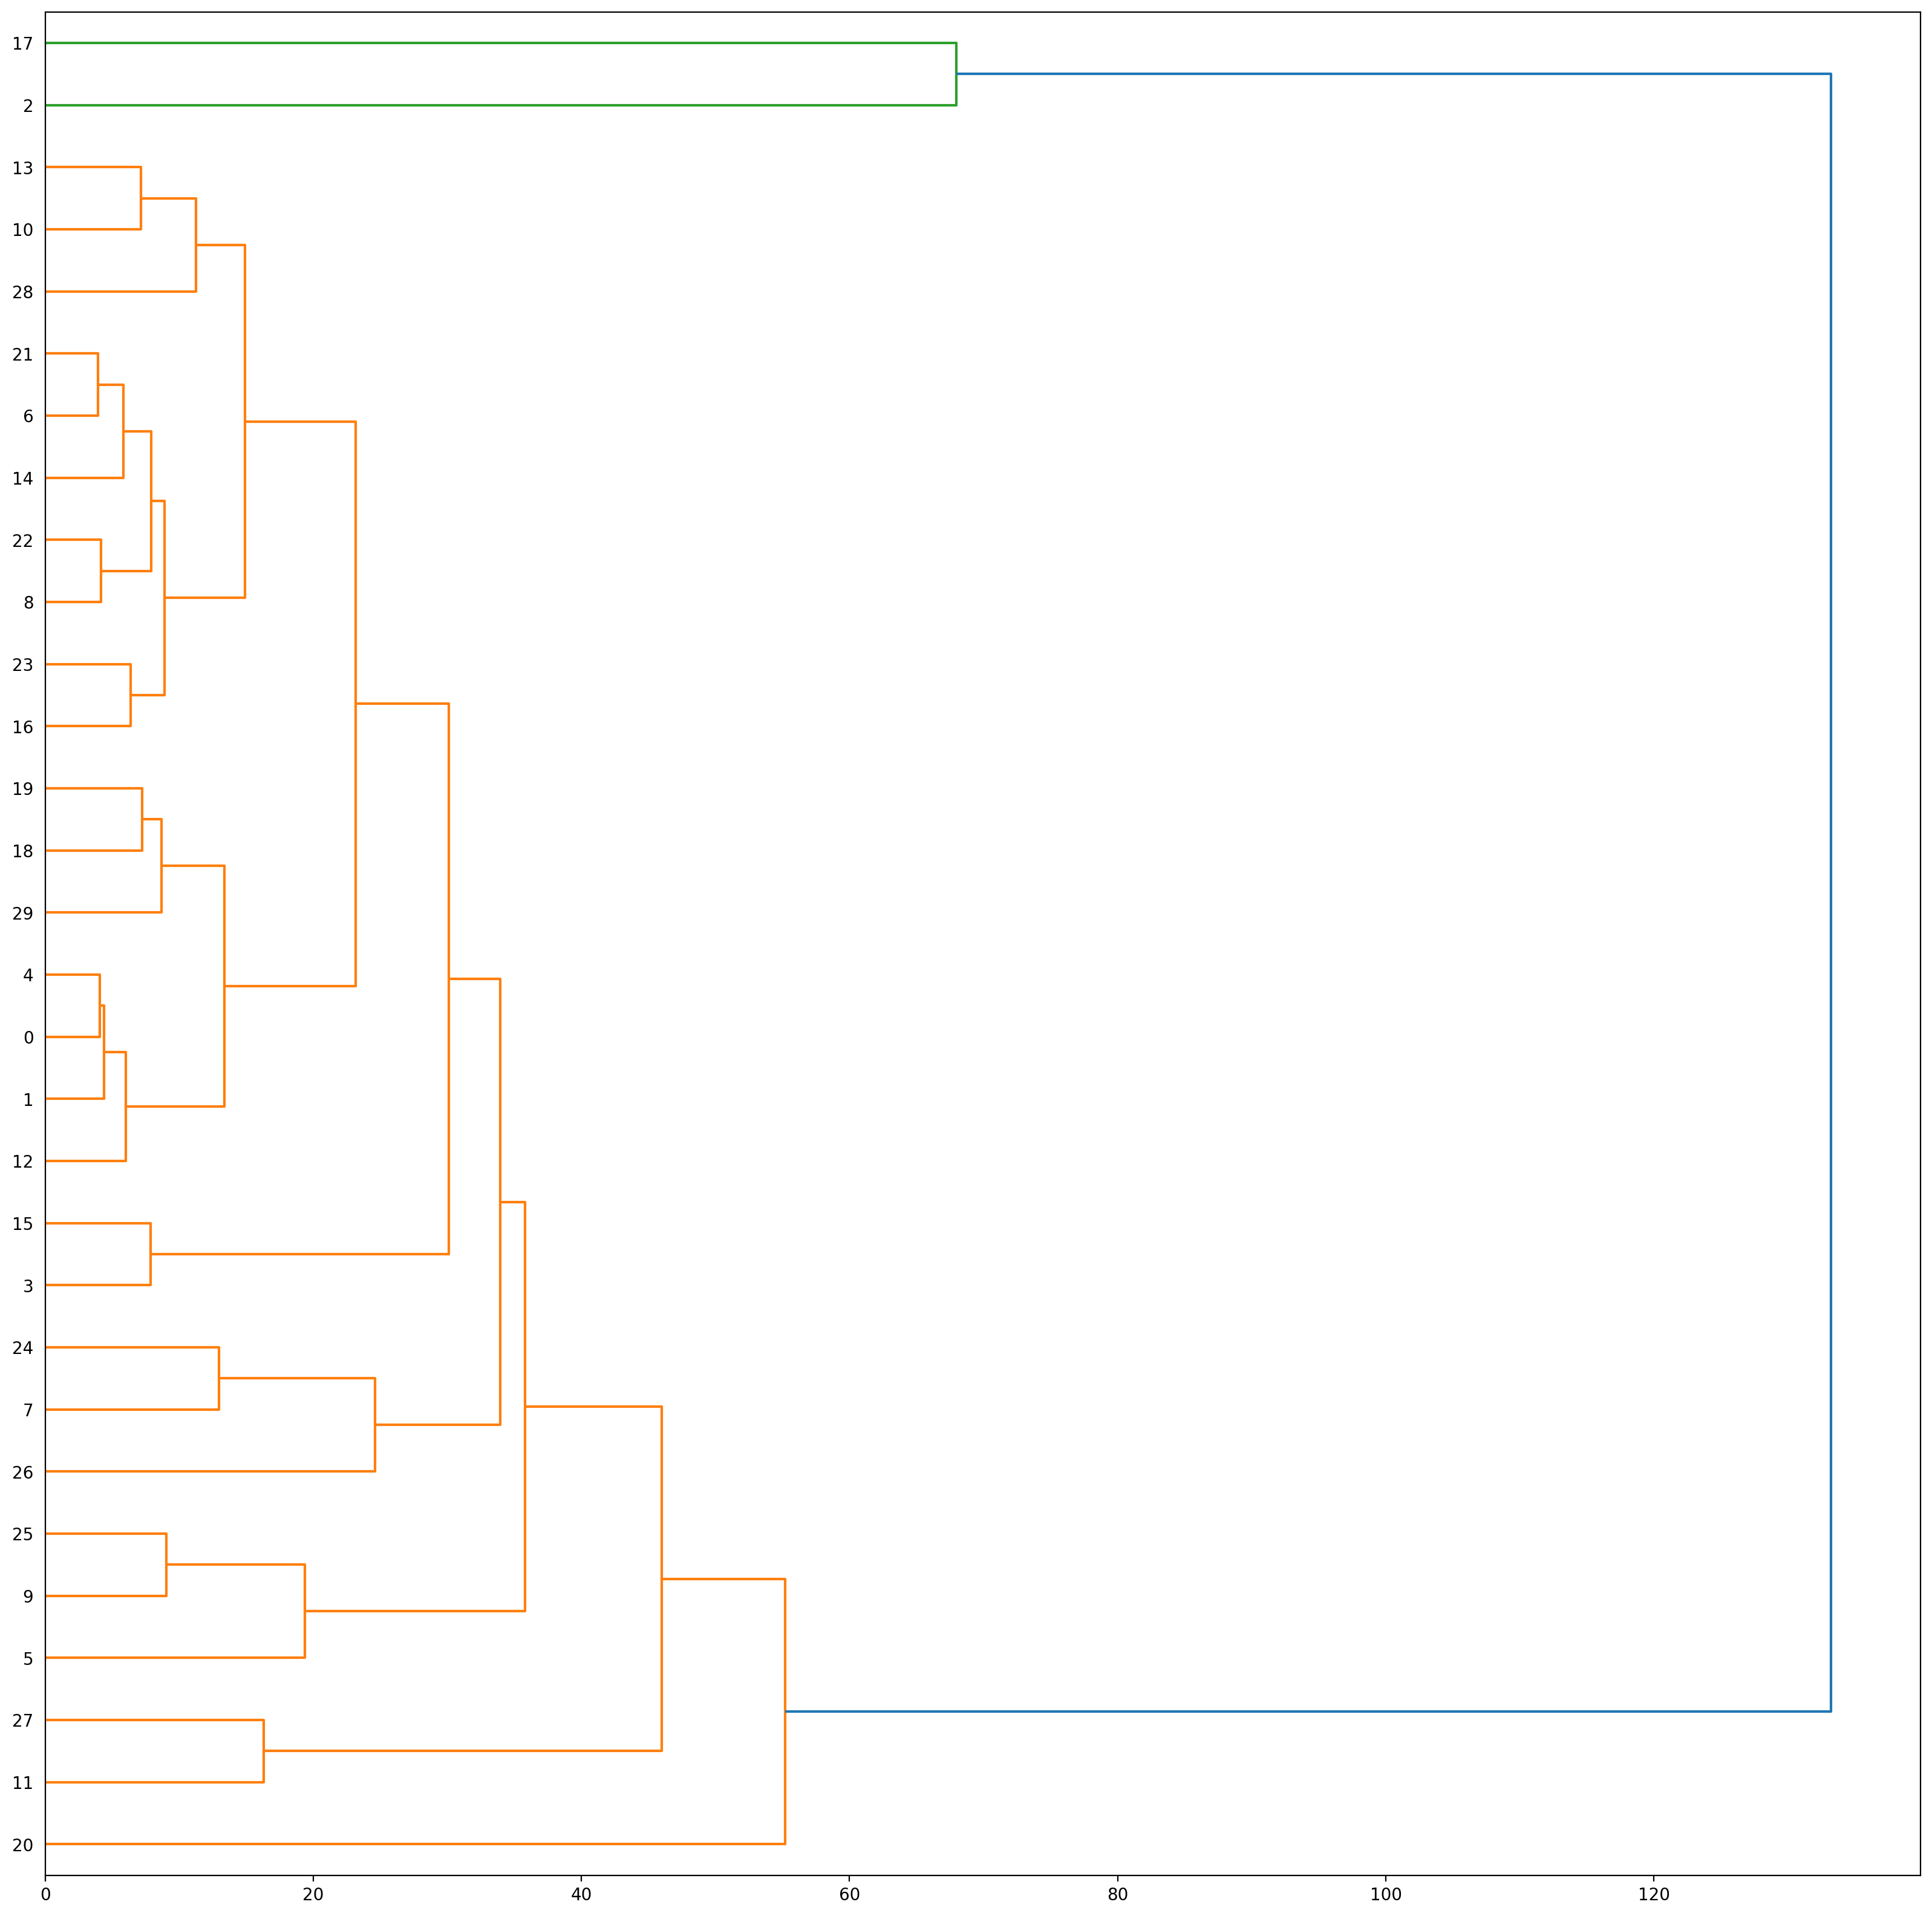

In [144]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster
from hdbscan.plots import SingleLinkageTree

fig,ax = plt.subplots(figsize=(20,20), dpi=200)
_ = dendrogram(linkage_matrix, ax=ax, orientation='right')

# fig, ax = plt.subplots(figsize=(20,10))
# SingleLinkageTree(linkage_matrix).plot(axis=ax)

In [145]:
cutoff = 1.25

In [146]:
ward_clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
ward_clusters = pd.Series(ward_clusters, index=np.arange(np.unique(kmeans_clusters).shape[0]))
np.unique(ward_clusters)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int32)

In [147]:
clusters = pd.Series(kmeans_clusters).map(lambda x: ward_clusters.loc[x]).values

In [148]:
clusters = kmeans_clusters.copy()

In [149]:
region_id = 69333


etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')
etcs['label'] = -1

morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

region_clusters = pd.Series(clusters, data.index)[data.index.str.startswith(str(region_id))]
region_clusters.index = region_clusters.index.str.slice(len(str(region_id)) + 1, )
region_clusters

morphotope_label
1005_0    28
1016_0    14
1016_1    22
1016_2     1
1018_0    26
          ..
978_0     14
979_0     16
991_0     14
997_0     22
9_0       22
Length: 1988, dtype: int32

In [150]:
region_clusters.nunique()

30

In [151]:
region_clusters.value_counts()

1     214
21    165
22    161
4     157
6     151
14    144
0     143
12    108
8     103
19     84
23     74
16     73
9      50
13     47
18     46
3      42
10     37
15     35
29     32
25     32
7      21
28     21
24     19
11     15
5       4
27      4
26      2
17      2
20      1
2       1
Name: count, dtype: int64

In [152]:
%%time
## assign morphotope clusters to tess cells

etcs.loc[morphotopes.index, 'label'] = morphotopes.morphotope_label.map(lambda x: region_clusters.loc[x] if x in region_clusters.index else -1).values



CPU times: user 1.12 s, sys: 59.6 ms, total: 1.18 s
Wall time: 1.12 s


In [153]:
# %%time
# # # # relabel morphotopes for plotting
# morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
#                        np.unique(morphotopes.values))
# etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
# etcs['morph'] = '-1'
# etcs.loc[morphotopes.index, 'morph'] = morphotopes.values

In [154]:
etcs.label.value_counts()

label
-1     108131
 1      35209
 14     31911
 21     29640
 4      28666
 0      25693
 6      24629
 22     20948
 12     18845
 19     17295
 23     13536
 8      12984
 16     12582
 9       9411
 3       8280
 13      8130
 18      7421
 25      6609
 29      6029
 15      5833
 10      5263
 7       4485
 24      2966
 28      2533
 11      2357
 5        897
 27       840
 17       406
 26       226
 20       120
 2        107
Name: count, dtype: int64

In [155]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 7.41 s, sys: 499 ms, total: 7.91 s
Wall time: 7.9 s


In [156]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [157]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(etcs.label)

In [44]:
1

1